In [79]:
# Импорт стандартных библиотек
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Импорт сторонних библиотек
from sklearn.metrics import (
    make_scorer, precision_score, recall_score, f1_score, classification_report
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
)

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

In [80]:
df = pd.read_parquet("../data/prepared_data.parquet")

# Модель "Прогнозирование оттока пользователей (Churn Prediction)"

# Задача: Предсказать, какие пользователи с высокой вероятностью не вернутся на сайт.
# Будем использовать несколько моделей, метриками качества будут выступать precision, recall, f1, время работы модели по прогнозированию

# Цель: верно определить, кто уйдёт (True Positive churn) — чтобы не пропустить пользователя, который уйдёт, направить ресурсы на удержание, повысив эффективность затрат.

# Для модели будем использовать фичи:

1. Таргет
next_visit

2. Количественные
pageViews
visitDuration_min
visits_before
days_last_visit

3. Категориальные
Source
UTMSource_category
weekday - уже закодировано
day_period
visitDuration_category
operatingSystem_category
type_device
regionCity - используем частотное кодирование, много значений

4. Бинарные
isNewUser
bounce
has_registration
registration_left
is_weekend

# Часть 1. Подготовка дата фрейма для модели

In [81]:
# инверсия значений столбца следующего визита, чтобы True было у тех, кто не вернётся - прогнозируем именно уходы
df['next_visit'] = ~df['next_visit']

In [82]:
# делаем копию дата фрейма для модели и удаляем ненужные колонки

df_model = df.copy()

df_model.drop(
    [
        'visitID',
        'date',
        'dateTime',
        'dateTimeUTC',
        'startURL',
        'endURL',
        'clientID',
        'counterUserIDHash',
        'mobilePhone',
        'operatingSystemRoot',
        'operatingSystem',
        'browser',
        'UTMCampaign',
        'UTMContent',
        'UTMMedium',
        'UTMSource',
        'UTMTerm',
        'visitDuration',
        'total_regs',
        'regionCountry',
        'referer',
        'lastTrafficSource',
        'referer_domain',
        'days_last_visit'
        ] , axis =1 ,inplace = True)

# Кодируем категориальные признаки, масштабируем количественные

In [83]:
# применяем fit_transform
# Определяем числовые столбцы
numeric_cols = df_model.select_dtypes(include='number').columns

# Создаём копии, чтобы не терять остальные признаки
df_model_scaled = df_model.copy()

# Масштабируем только числовые колонки
scaler = StandardScaler()
df_model_scaled[numeric_cols] = scaler.fit_transform(df_model[numeric_cols])

# используем частотное кодирование
city_freq = df_model['regionCity'].value_counts(normalize=True)
df_model['city_freq'] = df_model['regionCity'].map(city_freq)
df_model.drop(['regionCity'] , axis =1 ,inplace = True)

In [84]:
# для категориальных данных используем числовое кодирование
label_encoder = LabelEncoder()
selected_columns = ['Source',
                   'day_period',
                   'visitDuration_category',
                   'type_device',
                   'UTMSource_category',
                   'operatingSystem_category']

encoded_columns = {}
for col in selected_columns:
    df_model[col] = label_encoder.fit_transform(df_model[col])
    encoded_columns[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [85]:
# разобьем данные на обучающую и тестовую выборки
X = df_model.drop(columns=['next_visit'])
y = df_model['next_visit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape

(259990, 16)

C:\Users\Антон\AppData\Local\Temp\ipykernel_2424\2201571235.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='viridis')


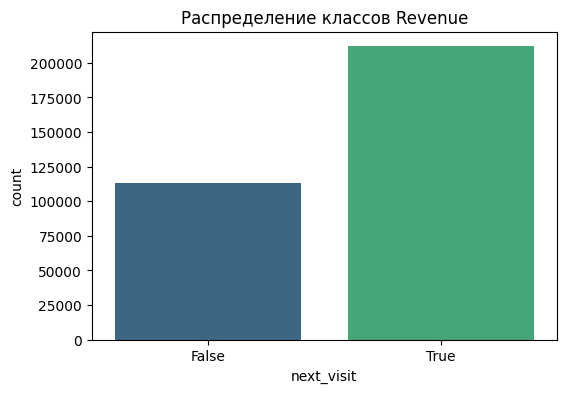

Соотношение классов:
 next_visit
True     0.651999
False    0.348001
Name: proportion, dtype: float64
1.5


In [86]:
# исследуем соотношение классов для таргета

plt.figure(figsize=(6, 4))
sns.countplot(x=y, palette='viridis')
plt.title('Распределение классов Revenue')
plt.show()

print("Соотношение классов:\n", df['next_visit'].value_counts(normalize=True))
print(round(len(df['next_visit'])/len(df[df['next_visit'] == 1]), 1))

# вывод: классы не сбалансированы

In [87]:
# создадим дата фрейм для сохранения метрик моделей и дальнейшего выбора модели
metrics = pd.DataFrame(index=['precision', 'recall', 'f1', 'time'])

# Часть 2. Запуск и сравнение моделей машинного обучения для выбора лучшей

# Модель 1. Бэггинг

In [88]:
models = {
    "BaggingClassifier": BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=50, random_state=42),
    "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=50, random_state=42)
}

# обучаем модели и выводим classification_report
start = time.time()
for name, model in models.items():
    print("="*30)
    print(f"Model: {name}")
    model.fit(X_train, y_train)  # обучаем модель

    y_pred = model.predict(X_test)  # предсказываем классы
    stop = time.time()
    # выводим classification_report
    print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['bagging'] = [precision, recall, f1, elapsed_time]

Model: BaggingClassifier
              precision    recall  f1-score   support

       False       0.78      0.67      0.72     22619
        True       0.84      0.90      0.87     42379

    accuracy                           0.82     64998
   macro avg       0.81      0.79      0.80     64998
weighted avg       0.82      0.82      0.82     64998

Model: RandomForestClassifier
              precision    recall  f1-score   support

       False       0.78      0.67      0.73     22619
        True       0.84      0.90      0.87     42379

    accuracy                           0.82     64998
   macro avg       0.81      0.79      0.80     64998
weighted avg       0.82      0.82      0.82     64998

Model: ExtraTreesClassifier
              precision    recall  f1-score   support

       False       0.74      0.69      0.71     22619
        True       0.84      0.87      0.85     42379

    accuracy                           0.81     64998
   macro avg       0.79      0.78      0.78  

# Модель 2. AdaBoost

In [89]:
start = time.time()

# Создаём и обучаем AdaBoost
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_ada))

precision = precision_score(y_test, y_pred_ada)
recall = recall_score(y_test, y_pred_ada)
f1 = f1_score(y_test, y_pred_ada)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['AdaBoost'] = [precision, recall, f1, elapsed_time]

              precision    recall  f1-score   support

       False       0.86      0.64      0.74     22619
        True       0.83      0.95      0.89     42379

    accuracy                           0.84     64998
   macro avg       0.85      0.79      0.81     64998
weighted avg       0.84      0.84      0.83     64998

время работы алгоритма: 7.5 секунд
Precision: 0.83
Recall: 0.95
F1 Score: 0.89


# Модель 3. GBM

In [90]:
start = time.time()

gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)
y_pred_gbm = gbm.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_gbm))

precision = precision_score(y_test, y_pred_gbm)
recall = recall_score(y_test, y_pred_gbm)
f1 = f1_score(y_test, y_pred_gbm)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['GBM'] = [precision, recall, f1, elapsed_time]

              precision    recall  f1-score   support

       False       0.87      0.65      0.74     22619
        True       0.83      0.95      0.89     42379

    accuracy                           0.84     64998
   macro avg       0.85      0.80      0.82     64998
weighted avg       0.85      0.84      0.84     64998

время работы алгоритма: 28.6 секунд
Precision: 0.83
Recall: 0.95
F1 Score: 0.89


# Модель 4. XGBoost

In [91]:
start = time.time()

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_xgb))

precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['XGBoost'] = [precision, recall, f1, elapsed_time]

              precision    recall  f1-score   support

       False       0.87      0.64      0.74     22619
        True       0.83      0.95      0.89     42379

    accuracy                           0.84     64998
   macro avg       0.85      0.80      0.81     64998
weighted avg       0.85      0.84      0.84     64998

время работы алгоритма: 1.0 секунд
Precision: 0.83
Recall: 0.95
F1 Score: 0.89


# Модель 5. LightGBM

In [92]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,   # Без ограничения глубины
    'num_leaves': 31,  # Стандартное значение
    'min_data_in_leaf': 5,  # Сделаем меньше, чтобы больше разбиений прошло
    'min_gain_to_split': 0.0,  # Уберем ограничение на минимальное улучшение сплита
    'feature_fraction': 0.8,
    'verbose':0
}
start = time.time()

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
y_pred_lgb = model.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_lgb))

precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['LightGBM'] = [precision, recall, f1, elapsed_time]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning]

# Модель 6. CatBoost

In [93]:
# подготовка данных для модели
df_cat = df.copy()
df_cat.drop(
    [
        'visitID',
        'date',
        'dateTime',
        'dateTimeUTC',
        'startURL',
        'endURL',
        'clientID',
        'counterUserIDHash',
        'mobilePhone',
        'operatingSystemRoot',
        'operatingSystem',
        'browser',
        'UTMCampaign',
        'UTMContent',
        'UTMMedium',
        'UTMSource',
        'UTMTerm',
        'visitDuration',
        'total_regs',
        'regionCountry',
        'referer',
        'lastTrafficSource',
        'referer_domain',
        'days_last_visit'
        ] , axis =1 ,inplace = True)

In [94]:
X_cat = df_cat.drop(columns=['next_visit'])
y_cat = df_cat['next_visit']
# разделяем данные на тренировочную (80%) и тестовую (20%) выборки с учетом дисбаланса (stratify=y)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, stratify=y, random_state=42)

# определяем категориальные признаки
cat_features = [
    'Source',
    'day_period',
    'visitDuration_category',
    'type_device',
    'UTMSource_category',
    'operatingSystem_category',
    'regionCity'
    ]
start = time.time()

# создаём и обучаем CatBoostClassifier
cat_model = cb.CatBoostClassifier(iterations=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)
cat_model.fit(X_train_cat, y_train_cat, cat_features=cat_features)
y_pred_cat = cat_model.predict(X_test_cat)

stop = time.time()
print(classification_report(y_test_cat, y_pred_cat))

precision = precision_score(y_test_cat, y_pred_cat)
recall = recall_score(y_test_cat, y_pred_cat)
f1 = f1_score(y_test_cat, y_pred_cat)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['CatBoost'] = [precision, recall, f1, elapsed_time]

              precision    recall  f1-score   support

       False       0.87      0.65      0.74     22619
        True       0.83      0.95      0.89     42379

    accuracy                           0.84     64998
   macro avg       0.85      0.80      0.82     64998
weighted avg       0.85      0.84      0.84     64998

время работы алгоритма: 8.1 секунд
Precision: 0.83
Recall: 0.95
F1 Score: 0.89


In [95]:
metrics.to_csv('../data/result_modelling.csv', index=False)

In [96]:
metrics

,bagging,AdaBoost,GBM,XGBoost,LightGBM,CatBoost
precision,0.838169,0.832215,0.834558,0.833189,0.836192,0.834588
recall,0.870408,0.945209,0.948677,0.950306,0.949173,0.949716
f1,0.853984,0.885120,0.887966,0.887902,0.889107,0.888438
time,91.222900,7.518000,28.643100,1.022100,1.758600,8.090700


# Выводы по запуску и сравнению нескольких моделей:

# 1. Лучше всего с задачей справились LightGBM и XGBoost
# Выберем LightGBM как более сбалансированную
- Recall = 0.949: поскольку цель — определить, кто уйдёт, ключевой метрикой становится полнота. Модель находит почти всех реально ушедших пользователей, пропуская лишь небольшую долю.
- Precision = 0.836: точность не идеальна — около 16% пользователей, которых модель посчитала "ушедшими", на самом деле остаются. Это означает, что модель иногда ошибается, «перестраховываясь», но, тем не менее, делает это не слишком часто.
- F1-score = 0.889: значение F1 указывает на хороший баланс между точностью и полнотой, что делает модель надёжной для практического применения.
- Время = 2.24 секунды: модель работает очень быстро и подходит для регулярного переобучения или применения в продакшене.

# Часть 3. Запуск наилучшей модели LightGBM, но без неважных признаков

# Модель 7. LightGBM без неважных фичей

In [97]:
# подготовим данные
df_lgb = df_model.copy()
df_lgb.drop([
    'bounce',
    'registration_left',
    'has_registration',
    'weekday',
    'is_weekend',
    'visits_before'
], axis =1 ,inplace = True)

In [98]:
# разобьем данные на обучающую и тестовую выборки
X = df_lgb.drop(columns=['next_visit'])
y = df_lgb['next_visit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape

(259990, 10)

In [99]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,   # Без ограничения глубины
    'num_leaves': 31,  # Стандартное значение
    'min_data_in_leaf': 5,  # Сделаем меньше, чтобы больше разбиений прошло
    'min_gain_to_split': 0.0,  # Уберем ограничение на минимальное улучшение сплита
    'feature_fraction': 0.8,
    'verbose':0
}
start = time.time()

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
y_pred_lgb = model.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_lgb))


precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['LightGBM_imp_feature'] = [precision, recall, f1, elapsed_time]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning]

In [100]:
metrics

,bagging,AdaBoost,GBM,XGBoost,LightGBM,CatBoost,LightGBM_imp_feature
precision,0.838169,0.832215,0.834558,0.833189,0.836192,0.834588,0.835941
recall,0.870408,0.945209,0.948677,0.950306,0.949173,0.949716,0.926520
f1,0.853984,0.885120,0.887966,0.887902,0.889107,0.888438,0.878903
time,91.222900,7.518000,28.643100,1.022100,1.758600,8.090700,1.782900


# Вывод: без неважных признаков модель стала хуже по метрикам качества - брать в работу не будем

# Часть 4. Запуск LightGBM с самостоятельным кодированием признаков

# Модель 8. LightGBM с самостоятельной обработкой категориальных признаков

In [101]:
cat_features = [
    'Source',
    'day_period',
    'visitDuration_category',
    'type_device',
    'UTMSource_category',
    'operatingSystem_category',
    'regionCity'
    ]  # категориальные фичи

df_lgb_categ = df.copy()

df_lgb_categ.drop(
    [
        'visitID',
        'date',
        'dateTime',
        'dateTimeUTC',
        'startURL',
        'endURL',
        'clientID',
        'counterUserIDHash',
        'mobilePhone',
        'operatingSystemRoot',
        'operatingSystem',
        'browser',
        'UTMCampaign',
        'UTMContent',
        'UTMMedium',
        'UTMSource',
        'UTMTerm',
        'visitDuration',
        'total_regs',
        'regionCountry',
        'referer',
        'lastTrafficSource',
        'referer_domain',
        'days_last_visit'
        ] , axis =1 ,inplace = True)

X = df_lgb_categ.drop(columns=['next_visit'])
y = df_lgb_categ['next_visit']

# разобьем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape

# Преобразуем их в тип category
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [102]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,   # Без ограничения глубины
    'num_leaves': 31,  # Стандартное значение
    'min_data_in_leaf': 5,  # Сделаем меньше, чтобы больше разбиений прошло
    'min_gain_to_split': 0.0,  # Уберем ограничение на минимальное улучшение сплита
    'feature_fraction': 0.8,
    'verbose':0
}
start = time.time()

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
y_pred_lgb = model.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_lgb))

precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['LightGBM_categ'] = [precision, recall, f1, elapsed_time]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_

In [103]:
metrics

,bagging,AdaBoost,GBM,XGBoost,LightGBM,CatBoost,LightGBM_imp_feature,LightGBM_categ
precision,0.838169,0.832215,0.834558,0.833189,0.836192,0.834588,0.835941,0.836226
recall,0.870408,0.945209,0.948677,0.950306,0.949173,0.949716,0.926520,0.948087
f1,0.853984,0.885120,0.887966,0.887902,0.889107,0.888438,0.878903,0.888651
time,91.222900,7.518000,28.643100,1.022100,1.758600,8.090700,1.782900,1.942400


# Вывод: метрики качества практически не поменялись - смысла использовать нет

# Часть 5. LightGBM с подбором гиперпараметров

# Модель 9. LightGBM с подбором гиперпараметров

In [104]:
# разобьем данные на обучающую и тестовую выборки
X = df_model.drop(columns=['next_visit'])
y = df_model['next_visit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape

(259990, 16)

In [105]:
# --- Создание модели ---
model = lgb.LGBMClassifier(objective='binary', verbose=0)

# --- Параметры для RandomizedSearchCV ---
param_dist = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [-1, 5, 10, 20, 50],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'min_child_samples': [5, 10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1, 5],
    'reg_lambda': [0, 0.1, 1, 5]
}

# --- Precision как метрика для повышения точности ---
scorer = make_scorer(precision_score)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    scoring=scorer,
    n_iter=50,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# --- Обучение модели ---
start = time.time()
random_search.fit(X_train, y_train)
stop = time.time()

best_model = random_search.best_estimator_

# --- Предсказания вероятностей и применение порога ---
y_proba = best_model.predict_proba(X_test)[:, 1]

# Изменяем порог — подбирай вручную: 0.5, 0.6, 0.65, 0.7 и т.д.
threshold = 0.65
y_pred_thresh = (y_proba >= threshold).astype(int)

# --- Метрики ---
precision = precision_score(y_test, y_pred_thresh)
recall = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
elapsed_time = round((stop - start), 2)

# --- Вывод ---
print("Best parameters:", random_search.best_params_)
print(f"Threshold: {threshold}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"Time: {elapsed_time} seconds")

metrics['LightGBM_giperparam'] = [precision, recall, f1, elapsed_time]

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 5, 'reg_alpha': 1, 'num_leaves': 127, 'min_child_samples': 50, 'max_depth': -1, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
Threshold: 0.65
Precision: 0.862
Recall: 0.890
F1-score: 0.876
Time: 257.96 seconds


In [106]:
metrics

,bagging,AdaBoost,GBM,XGBoost,LightGBM,CatBoost,LightGBM_imp_feature,LightGBM_categ,LightGBM_giperparam
precision,0.838169,0.832215,0.834558,0.833189,0.836192,0.834588,0.835941,0.836226,0.861586
recall,0.870408,0.945209,0.948677,0.950306,0.949173,0.949716,0.926520,0.948087,0.890394
f1,0.853984,0.885120,0.887966,0.887902,0.889107,0.888438,0.878903,0.888651,0.875753
time,91.222900,7.518000,28.643100,1.022100,1.758600,8.090700,1.782900,1.942400,257.960000


# Вывод: улучшения precision есть, но остальные метрики заметно снизились - смысла использовать нет

# Часть 6. LightGBM с удалением из исходных данных выбросов и нулей

# Модель 11. LightGBM без выбросов

In [107]:
df_model = df_model.loc[
    (df_model['visitDuration_min'] != 0) &
    (df_model['pageViews']        != 0)
]

In [108]:
# разобьем данные на обучающую и тестовую выборки
X = df_model.drop(columns=['next_visit'])
y = df_model['next_visit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
X_train.shape

(231354, 16)

In [109]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': -1,   # Без ограничения глубины
    'num_leaves': 31,  # Стандартное значение
    'min_data_in_leaf': 5,  # Сделаем меньше, чтобы больше разбиений прошло
    'min_gain_to_split': 0.0,  # Уберем ограничение на минимальное улучшение сплита
    'feature_fraction': 0.8,
    'verbose':0,
    'scale_pos_weight': 2.3
}
start = time.time()

model = lgb.LGBMClassifier(**params)
model.fit(X_train, y_train)
y_pred_lgb = model.predict(X_test)

stop = time.time()
print(classification_report(y_test, y_pred_lgb))


precision = precision_score(y_test, y_pred_lgb)
recall = recall_score(y_test, y_pred_lgb)
f1 = f1_score(y_test, y_pred_lgb)
elapsed_time = round((stop - start), 4)

print(f'время работы алгоритма: {elapsed_time:.1f} секунд')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

metrics['LightGBM_no_zeros'] = [precision, recall, f1, elapsed_time]

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning]

In [110]:
metrics

,bagging,AdaBoost,GBM,XGBoost,LightGBM,CatBoost,LightGBM_imp_feature,LightGBM_categ,LightGBM_giperparam,LightGBM_no_zeros
precision,0.838169,0.832215,0.834558,0.833189,0.836192,0.834588,0.835941,0.836226,0.861586,0.804182
recall,0.870408,0.945209,0.948677,0.950306,0.949173,0.949716,0.926520,0.948087,0.890394,0.977936
f1,0.853984,0.885120,0.887966,0.887902,0.889107,0.888438,0.878903,0.888651,0.875753,0.882588
time,91.222900,7.518000,28.643100,1.022100,1.758600,8.090700,1.782900,1.942400,257.960000,2.069000


In [111]:
metrics.to_csv('../data/result_modelling.csv', index=False)

# Вывод: recall стал почти идеальным, но упал precision, также f1 упал. Использовать не будем, но при необходимости идеального recall можно взять этот вариант модели

# Итоги по тестированию моделей:

Модель LightGBM хорошо справляется с задачей: она почти не пропускает тех, кто действительно уйдёт (высокая полнота), но иногда ошибочно помечает как "ушедших" тех, кто на самом деле остался (не идеальная точность). В целом, она даёт сбалансированные предсказания и работает быстро.
Precision = 0.836 - из всех, кого модель предсказала как "ушёл", 83.6% действительно ушли.
Recall = 0.949 - из всех реально ушедших, модель нашла 94.9%, целевая метрика качества.
F1-score = 0.889 - хороший баланс.

При необходимости повысить recall можно использовать LightGBM с удалением из исходных данных выбросов и нулей (recall = 0.977), но при этом падает precision (0.804)

При необходимости повысить precision можно использовать LightGBM с подбором гиперпараметров (precision = 0.861), но при этом будет падение recall (0.890), однако модель станет более сбалансированной